In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from random import random
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv').dropna().drop_duplicates().reset_index(drop=True)
df.tail(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6603,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
6604,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
6605,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


### pre-process

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 677.5+ KB


In [31]:
df['Deck'] = [item.split('/')[0] for item in df.Cabin]
df['Num'] = pd.to_numeric([item.split('/')[1] for item in df.Cabin])
df['Side'] = [item.split('/')[2] for item in df.Cabin]
df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
6601,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
6602,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
6603,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
6604,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S
6605,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True,E,608,S


### EDA + Feature engineering

In [32]:
# scale numeric columns
OUTLIER_LIMIT = 3
df['outlier'] = False

for column in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
    df[column] = StandardScaler().fit_transform(df[[column]])
    mean = df[column].mean()
    std = df[column].std()
    df.loc[np.abs(df[column]) > (mean + OUTLIER_LIMIT*std),'outlier'] = True

df.describe()    

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num
count,6606.000000,6.606000e+03,6.606000e+03,6.606000e+03,6.606000e+03,6.606000e+03,6606.000000
mean,28.894036,-1.535254e-16,-7.690555e-17,9.467483e-16,-3.443439e-16,4.167118e-16,599.177414
std,14.533429,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,513.450585
min,0.000000,-3.457562e-01,-2.853550e-01,-3.094937e-01,-2.737594e-01,-2.695339e-01,0.000000
25%,19.000000,-3.457562e-01,-2.853550e-01,-3.094937e-01,-2.737594e-01,-2.695339e-01,166.000000
50%,27.000000,-3.457562e-01,-2.853550e-01,-3.094937e-01,-2.737594e-01,-2.695339e-01,424.000000
75%,38.000000,-2.697800e-01,-2.360541e-01,-2.574361e-01,-2.169377e-01,-2.233960e-01,994.000000
max,79.000000,1.503554e+01,1.747670e+01,2.095256e+01,1.931486e+01,1.777392e+01,1894.000000


In [33]:
num_dict = {}
for column in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Age']:
    num_dict.update({column:stats.ttest_ind(df.loc[df.Transported==True,column], df.loc[df.Transported==False,column])})

num_dict    

{'RoomService': Ttest_indResult(statistic=-20.740249962919606, pvalue=1.2773942483651054e-92),
 'FoodCourt': Ttest_indResult(statistic=4.478362881463671, pvalue=7.648322367725269e-06),
 'ShoppingMall': Ttest_indResult(statistic=0.9428779395650722, pvalue=0.34577783054022204),
 'Spa': Ttest_indResult(statistic=-18.314563876212162, pvalue=3.9970291241661626e-73),
 'VRDeck': Ttest_indResult(statistic=-17.276704592398897, pvalue=1.9036144514996305e-65)}

In [35]:
# include only significant numeric features:
X = ['RoomService','FoodCourt','Spa','VRDeck']

,Transported,Destination,dest_trans_rate
0,False,TRAPPIST-1e,0.467
1,True,TRAPPIST-1e,0.467
2,False,TRAPPIST-1e,0.467
3,False,TRAPPIST-1e,0.467
4,True,TRAPPIST-1e,0.467


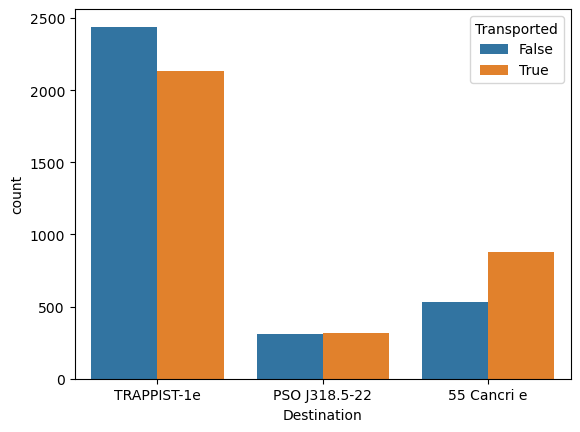

In [36]:
sns.countplot(data=df,x='Destination',hue='Transported')
df['dest_trans_rate'] = None
df['dest_trans_rate'] = [round(len(df[(df.Transported==True)&(df.Destination==item)])/len(df[df.Destination==item]),3) for item in df.Destination]
df[['Transported','Destination','dest_trans_rate']].head()

,Transported,VIP,vip_apr_rate
0,False,False,0.693
1,True,False,0.693
2,False,True,0.693
3,False,False,0.693
4,True,False,0.693


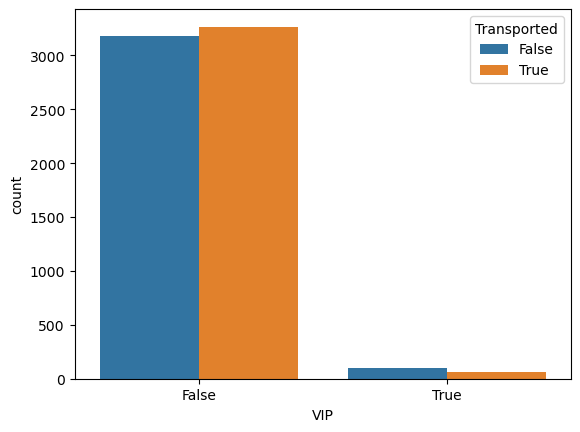

In [37]:
sns.countplot(data=df,x='VIP',hue='Transported')
df['vip_apr_rate'] = None
df['vip_apr_rate'] = [round(len(df[df.Destination==item])/len(df),3) for item in df.Destination]
df[['Transported','VIP','vip_apr_rate']].head()

,Transported,HomePlanet,home_trans_rate
0,False,Europa,0.660
1,True,Earth,0.426
2,False,Europa,0.660
3,False,Europa,0.660
4,True,Earth,0.426


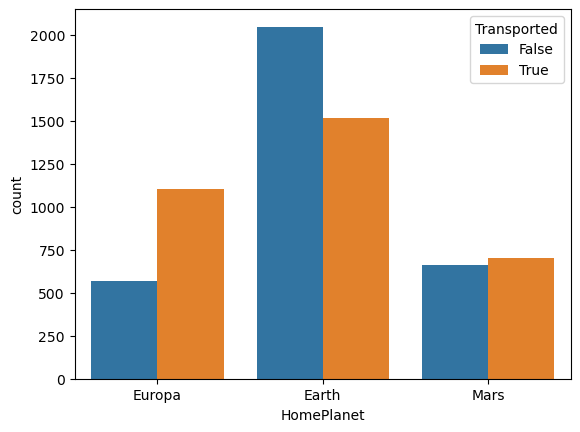

In [38]:
sns.countplot(data=df,x='HomePlanet',hue='Transported')
df['home_trans_rate'] = None
df['home_trans_rate'] = [round(len(df[(df.Transported==True)&(df.HomePlanet==item)])/len(df[df.HomePlanet==item]),3) for item in df.HomePlanet]
df[['Transported','HomePlanet','home_trans_rate']].head()

<AxesSubplot:xlabel='Transported', ylabel='Num'>

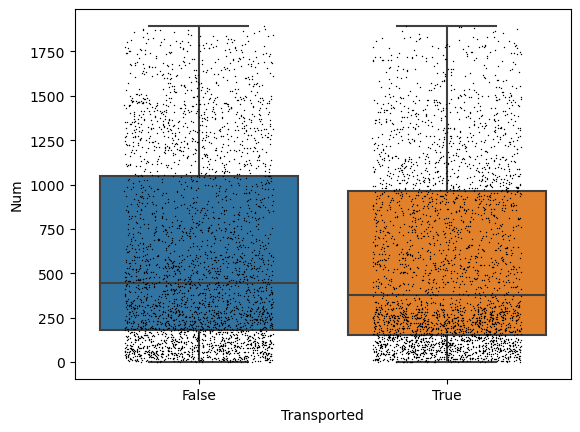

In [39]:
sns.boxplot(data=df,x='Transported',y='Num')
sns.stripplot(data=df,x='Transported',y='Num',size=1,jitter=0.3,color='black')

,Transported,Deck,deck_trans_rate
0,False,B,0.729
1,True,F,0.435
2,False,A,0.488
3,False,A,0.488
4,True,F,0.435


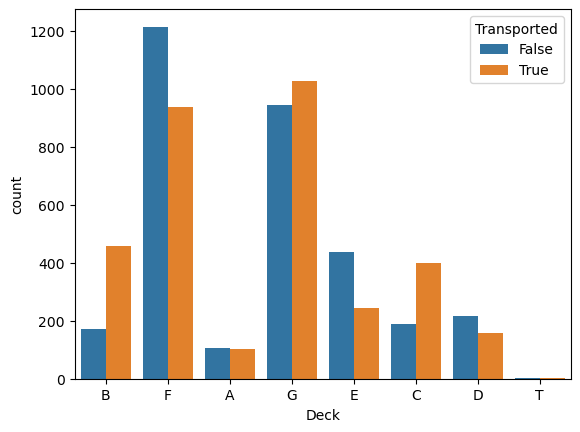

In [40]:
sns.countplot(data=df,x='Deck',hue='Transported')
df['deck_trans_rate'] = None
df['deck_trans_rate'] = [round(len(df[(df.Transported==True)&(df.Deck==item)])/len(df[df.Deck==item]),3) for item in df.Deck]
df[['Transported','Deck','deck_trans_rate']].head()

,Transported,Side,side_trans_rate
0,False,P,0.450
1,True,S,0.556
2,False,S,0.556
3,False,S,0.556
4,True,S,0.556


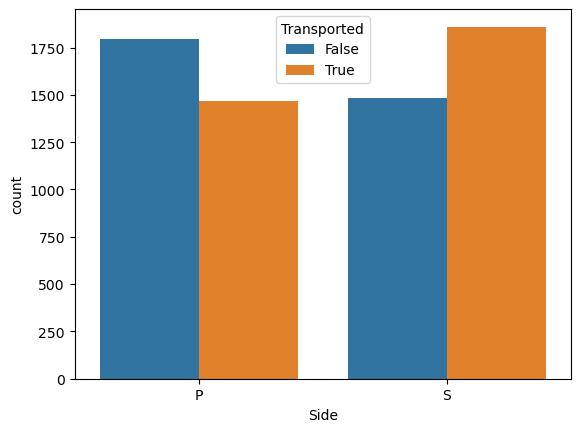

In [41]:
sns.countplot(data=df,x='Side',hue='Transported')
df['side_trans_rate'] = None
df['side_trans_rate'] = [round(len(df[(df.Transported==True)&(df.Side==item)])/len(df[df.Side==item]),3) for item in df.Side]
df[['Transported','Side','side_trans_rate']].head()

,Transported,CryoSleep,cryo_sleep_trans_rate
0,False,False,0.333
1,True,False,0.333
2,False,False,0.333
3,False,False,0.333
4,True,False,0.333


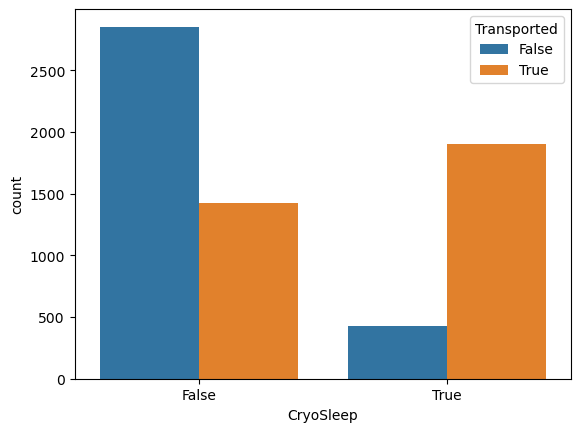

In [42]:
sns.countplot(data=df,x='CryoSleep',hue='Transported')
df['cryo_sleep_trans_rate'] = None
df['cryo_sleep_trans_rate'] = [round(len(df[(df.Transported==True)&(df.CryoSleep==item)])/len(df[df.CryoSleep==item]),3) for item in df.CryoSleep]
df[['Transported','CryoSleep','cryo_sleep_trans_rate']].head()

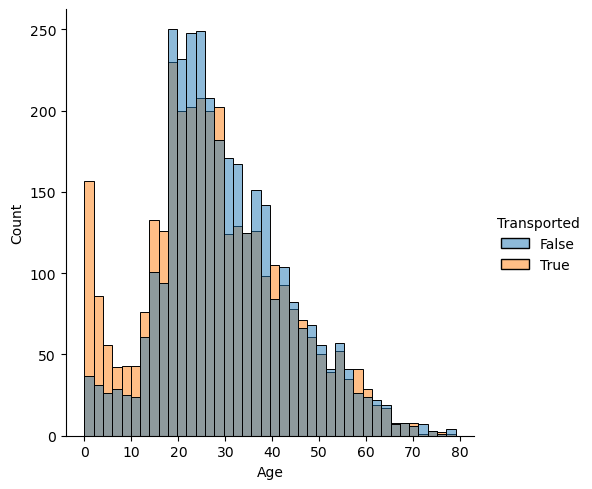

In [43]:
sns.displot(data=df,x='Age',hue='Transported')

In [44]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Deck', 'Num', 'Side', 'outlier',
       'dest_trans_rate', 'vip_apr_rate', 'home_trans_rate', 'deck_trans_rate',
       'side_trans_rate', 'cryo_sleep_trans_rate'],
      dtype='object')

In [48]:
# test categorical features significance:
cat_dict = {}
for column in ['dest_trans_rate','vip_apr_rate','home_trans_rate','deck_trans_rate','side_trans_rate','cryo_sleep_trans_rate']:
    cat_dict.update({column:stats.chi2_contingency(pd.crosstab(df[column], df['Transported']))[1]})

cat_dict    

{'dest_trans_rate': 2.0065472274358898e-23,
 'vip_apr_rate': 2.006547227435919e-23,
 'home_trans_rate': 3.337896081387072e-55,
 'deck_trans_rate': 3.2179345727714256e-63,
 'side_trans_rate': 7.57176861496441e-18,
 'cryo_sleep_trans_rate': 3.170181308462424e-309}

In [49]:
X.extend(['dest_trans_rate','vip_apr_rate','home_trans_rate','deck_trans_rate','side_trans_rate','cryo_sleep_trans_rate'])
X

['RoomService',
 'FoodCourt',
 'Spa',
 'VRDeck',
 'dest_trans_rate',
 'vip_apr_rate',
 'home_trans_rate',
 'deck_trans_rate',
 'side_trans_rate',
 'cryo_sleep_trans_rate']

### classification model

In [50]:
# model parameters
y = 'Transported'
X = X

df = df[X + [y] + ['outlier']]

TEST_AMOUNT = 0.3
EXCLUDE_OUTLIERS = True
print(f'X:{X}\ny:{y}\nTest set:{TEST_AMOUNT}\nTrain set:{1-TEST_AMOUNT}\nExclude Outliers:{EXCLUDE_OUTLIERS}')

# test train classification
df['set'] = None
df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
df.set.value_counts()

X:['RoomService', 'FoodCourt', 'Spa', 'VRDeck', 'dest_trans_rate', 'vip_apr_rate', 'home_trans_rate', 'deck_trans_rate', 'side_trans_rate', 'cryo_sleep_trans_rate']
y:Transported
Test set:0.3
Train set:0.7
Exclude Outliers:True


train    4592
test     2014
Name: set, dtype: int64

In [51]:
# fit a voting classifier
if EXCLUDE_OUTLIERS:
    df = df[df.outlier==False].reset_index(drop=True)

X_train = df[df['set'] == 'train'][X]
y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))

rf = RandomForestClassifier(random_state=42)

voting_classifier = VotingClassifier(
    estimators=[('rf',RandomForestClassifier(random_state=42)),
                ('xgb',XGBClassifier(random_state=42)),
                #('lr',LogisticRegression(random_state=42)),
                ('svm',SVC(probability=True, random_state=42)), 
                ('knn',KNeighborsClassifier()), 
                ('dt',DecisionTreeClassifier(random_state=42))],
    voting='soft'  # 'soft' for weighted voting based on probabilities, 'hard' for majority voting
)

rf.fit(X=X_train,y=y_train)
voting_classifier.fit(X=X_train,y=y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_...
                                            max_delta_step=None, max_depth=None,
                                            max_le

In [52]:
# profile training data:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RoomService,6026.0,-0.107265,0.567225,-0.345756,-0.345756,-0.345756,-0.294589,2.997195
FoodCourt,6026.0,-0.132702,0.452243,-0.285355,-0.285355,-0.285355,-0.272248,2.991448
Spa,6026.0,-0.122098,0.422028,-0.273759,-0.273759,-0.273759,-0.247534,2.989553
VRDeck,6026.0,-0.127139,0.399084,-0.269534,-0.269534,-0.269534,-0.252676,2.991171
dest_trans_rate,6026.0,0.502039,0.061458,0.467000,0.467000,0.467000,0.506000,0.623000
vip_apr_rate,6026.0,0.536699,0.240457,0.094000,0.213000,0.693000,0.693000,0.693000
home_trans_rate,6026.0,0.494460,0.093157,0.426000,0.426000,0.426000,0.516000,0.660000
deck_trans_rate,6026.0,0.496864,0.102895,0.359000,0.435000,0.488000,0.521000,0.729000
side_trans_rate,6026.0,0.503545,0.053002,0.450000,0.450000,0.556000,0.556000,0.556000
cryo_sleep_trans_rate,6026.0,0.520303,0.235757,0.333000,0.333000,0.333000,0.817000,0.817000


In [53]:
K_FOLD = 5
acc_values = []
for fold in range(1,K_FOLD+1):
    
    df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
    #print(f'{df.set.value_counts()}')
    
    X_train = df[df['set'] == 'train'][X]
    y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))
    voting_classifier.fit(X=X_train,y=y_train)
    df[f'{y}_pred_fold{fold}'] = voting_classifier.predict(df[X])
    df[f'{y}_proba_fold{fold}'] = [np.round(max(item),3) for item in voting_classifier.predict_proba(df[X])]

    d = df[df.set=='test']
    acc = np.round(len(d[d[f"{y}_pred_fold{fold}"]==d[y]])/(len(d)),3)
    acc_values.append(acc)
    print(f'Fold_{fold}; Accuracy: {acc}')

print(f'\nMean folds accuracy: {np.round(np.mean(acc_values),3)}')
df.head() 

Fold_1; Accuracy: 0.788
Fold_2; Accuracy: 0.798
Fold_3; Accuracy: 0.794
Fold_4; Accuracy: 0.777
Fold_5; Accuracy: 0.783

Mean folds accuracy: 0.788


,RoomService,FoodCourt,Spa,VRDeck,dest_trans_rate,vip_apr_rate,home_trans_rate,deck_trans_rate,side_trans_rate,cryo_sleep_trans_rate,Transported,outlier,set,Transported_pred_fold1,Transported_proba_fold1,Transported_pred_fold2,Transported_proba_fold2,Transported_pred_fold3,Transported_proba_fold3,Transported_pred_fold4,Transported_proba_fold4,Transported_pred_fold5,Transported_proba_fold5
0,-0.345756,-0.285355,-0.273759,-0.269534,0.467,0.693,0.660,0.729,0.450,0.333,False,False,train,False,0.573,False,0.524,False,0.551,False,0.532,False,0.683
1,-0.176748,-0.279993,0.206165,-0.230494,0.467,0.693,0.426,0.435,0.556,0.333,True,False,train,True,0.551,True,0.604,True,0.564,True,0.572,True,0.581
2,-0.345756,0.479034,2.636384,-0.098291,0.467,0.693,0.660,0.488,0.556,0.333,False,False,test,False,0.967,False,0.967,False,0.964,False,0.966,False,0.923
3,0.124056,-0.243650,0.220152,-0.267759,0.467,0.693,0.426,0.435,0.556,0.333,True,False,train,True,0.584,True,0.623,True,0.604,True,0.560,True,0.530
4,-0.345756,0.002408,-0.019373,-0.269534,0.506,0.094,0.426,0.435,0.450,0.333,True,False,train,True,0.571,True,0.622,True,0.618,True,0.577,True,0.591


In [19]:
dict(zip(rf.feature_names_in_,rf.feature_importances_))

{'Age': 0.18984516060072046,
 'RoomService': 0.1289397630258968,
 'FoodCourt': 0.09642908389617495,
 'ShoppingMall': 0.07702094221383045,
 'Spa': 0.12287056269207236,
 'VRDeck': 0.10781045789479136,
 'dest_trans_rate': 0.01568567063631614,
 'vip_apr_rate': 0.013789338839725033,
 'home_trans_rate': 0.061304730486294715,
 'deck_trans_rate': 0.06093680474293596,
 'side_trans_rate': 0.025555980222122417,
 'cryo_sleep_trans_rate': 0.09981150474911939}

In [20]:
>>>>>

SyntaxError: invalid syntax (1849256487.py, line 1)

In [ ]:
t = pd.read_csv('test.csv').dropna().reset_index(drop=True)
t.tail(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
3278,9266_01,Earth,False,F/1796/S,TRAPPIST-1e,40.0,False,0.0,865.0,0.0,3.0,0.0,Danna Peter
3279,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
3280,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley


In [ ]:
t['trans_predict'] = voting_classifier.predict(t[X])
t

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,trans_predict
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,False
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,False
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,False
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,9263_01,Earth,True,G/1495/S,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Loisey Heney,False
3277,9265_01,Mars,False,D/278/S,TRAPPIST-1e,43.0,False,47.0,0.0,3851.0,0.0,0.0,Toate Cure,False
3278,9266_01,Earth,False,F/1796/S,TRAPPIST-1e,40.0,False,0.0,865.0,0.0,3.0,0.0,Danna Peter,False
3279,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,False
